# Homework $\gamma$ - Digit recognition with neural networks
### Course on Optimization for Machine Learning - Dr. F. Ballarin
### Master Degree in Data Analytics for Business, Catholic University of the Sacred Heart, Milano

FRANCESCA GHIDINI 
5007699

In [6]:
import pandas as pd
import numpy as np
import plotly.subplots
import jax
import jax.numpy as jnp
import typing
import os
from plotly.subplots import make_subplots
import pandas as pd
import plotly.graph_objects as go
import plotly.express as px
import plotly.io as pio
pio.templates.default = "plotly_white"
import sklearn
from sklearn import metrics
from sklearn import preprocessing
import seaborn as sns
import matplotlib.pyplot as plt


## Homework $\gamma$.1

The *MNIST database* (Modified National Institute of Standards and Technology database) is a database of handwritten digits that is commonly used for testing new algorithms in the field of machine learning. The database collects images of handwritten digits $0, 1, 2, \dots, 9$ by a group of American Census Bureau employees and a group of American high school students. The handwritten digits have been stored as 28x28 pixel grayscale images, with grayscale levels ranging from 0 to 255.

The database has been divided in training (`mnist_train_small.csv`) and testing (`mnist_test.csv`) datasets, which you may find on Colab in the `sample_data` folder, or on Blackboard. Each row of the `csv` file represents an entry of the dataset (i.e., an image of an handwritten digit). The first column stores the value of the digit represented in the image, while each of the remaining $28 \times 28 = 784$ columns stores the grayscale level of a single pixel of the image.

The goal of this homework is to set up a digit *recognition* (i.e., *classification* in data analysis), that using a feedforward neural network is able to predict the value of the digit (i.e., the *label*, in data analysis) of the handwritten image based on the pixels of the image (i.e., the *features*, in data analysis).

1. Read in the training dataset $(\boldsymbol{X}_{\text{train}}, \boldsymbol{Y}_{\text{train}})$, where
   * $\boldsymbol{Y}_{\text{train}}$ is a matrix with as many rows as the training dataset and 10 columns, obtained applying one-hot encoding to the first column of the file `mnist_train_small.csv`;
   * $\boldsymbol{X}_{\text{train}}$ is a matrix with as many rows as the training dataset and 784 columns, obtained normalizing between 0 and 1 the remanining columns of the file `mnist_train_small.csv`.
 
   *Hints*: in contrast to other datasets, the `csv` files associated to this case does not have a header (i.e., a name to be associated to each column). Use the instruction `pd.read_csv(..., header=None)` when reading in the dataset to inform `pandas` that no header is present in a `csv` file. Furthermore, to refer to the columns of the `pandas.DataFrame` object you should use the column number (i.e., column `0` corresponds to the labels and columns `1:` correspond to the features).

Import the `mnist_train` dataset:



In [7]:
train = pd.read_csv('/content/sample_data/mnist_train_small.csv',  header=None)  #import the csv

In [8]:
train.head()

,0,1,2,3,4,5,6,7,8,9,...,775,776,777,778,779,780,781,782,783,784
0,6,0,0,0,0,0,0,0,0,0,...,0,0,0,0,0,0,0,0,0,0
1,5,0,0,0,0,0,0,0,0,0,...,0,0,0,0,0,0,0,0,0,0
2,7,0,0,0,0,0,0,0,0,0,...,0,0,0,0,0,0,0,0,0,0
3,9,0,0,0,0,0,0,0,0,0,...,0,0,0,0,0,0,0,0,0,0
4,5,0,0,0,0,0,0,0,0,0,...,0,0,0,0,0,0,0,0,0,0


Create the `Y_train` that contains the true label of the images converted in the hot-encoded format:

In [9]:
Y_train = jax.nn.one_hot(train[0], 10)
print(Y_train)

[[0. 0. 0. ... 0. 0. 0.]
 [0. 0. 0. ... 0. 0. 0.]
 [0. 0. 0. ... 1. 0. 0.]
 ...
 [0. 0. 1. ... 0. 0. 0.]
 [0. 0. 0. ... 0. 0. 1.]
 [0. 0. 0. ... 0. 0. 0.]]


In [10]:
Y_train.shape #shape check

(20000, 10)

In [11]:
type(Y_train)

jaxlib.xla_extension.DeviceArray

Create the `X_train` array containing the features values normalized: $x_{scaled} = \frac{x - min(x)}{max(x)-min(x)}$

In [12]:
X_train = train.drop([0], axis=1) #remove first column of the train dataset

In [13]:
x_scaled = (X_train.values - np.min(X_train.values))/(np.max(X_train.values)- np.min(X_train.values)) #normalizing values
X_train = pd.DataFrame(x_scaled).to_numpy() 

In [14]:
X_train.shape #shape check

(20000, 784)

In [15]:
type(X_train)

numpy.ndarray

2. Use the following Python function to visualize the first 50 images in the training dataset and their corresponding labels. The function `visualize_digits_and_labels` accepts two input arguments `X` and `Y`, corresponding respectively to the matrix of features and the matrix of one-hot encoded labels. Extract the first 50 entries from the training dataset to construct the appropriate input arguments.

In [16]:
def visualize_digits_and_labels(X: np.ndarray, Y: np.ndarray) -> None:
    """Visualize digits as images and labels as titles."""
    # Check input arguments
    assert X.shape[0] == Y.shape[0]
    m = X.shape[0]
    assert X.shape[1] == 28 * 28
    assert Y.shape[1] == 10
    
    # Reverse one-hot encoding to determine the digit number
    digits = np.argwhere(Y == 1)[:, 1]
    
    # Create a new figure with 10 images per row, and assign titles to each subplot
    ncols = 10
    nrows = int(np.ceil(X.shape[0] / ncols))
    assert nrows < 6, "Do not try to plot more than 50 images"
    fig = plotly.subplots.make_subplots(rows=nrows, cols=ncols, subplot_titles=[str(d) for d in digits])

    # Loop over images and add to subplot
    j = 0
    for row in range(nrows):
        for col in range(ncols):
            if j >= m:
                break

            img_j = X[j].reshape((28, 28))
            fig.add_heatmap(z=img_j, colorscale="gray_r", showscale=False, row=row + 1, col=col + 1)
            j += 1

    fig.update_yaxes(autorange="reversed", constrain="domain", scaleanchor="x", showticklabels=False)
    fig.update_xaxes(constrain="domain", showticklabels=False)
    fig.show()

In [17]:
visualize_digits_and_labels(X_train[0:50], Y_train[0:50])

3. Use the Glorot initialization to initialize the weights and biases associated to a feedforward neural network with two hidden layers, composed of 50 and 30 neurons respectively. How many neurons should the input layer have? How many neurons should the output layer have?

   For reproducibility, please set the *seed* `np.random.seed(31 + 300)` at the beginning of the cell where initialization is performed.

Since it is not expressed in the text, the number of neurons in the input layer will be equal to the number of features (i.e. 784). The output layer will be composed of 10 neurons that are the number of classification classes. So, at the end there will be:
- 784 neurons in the input layer
- 50 neurons in the first hidden layer (as it is stated in the text)
- 30 neurons in the second hidden layer (as it is stated in the text)
- 10 neurons in the output layer

The neural network is therefore defined by:

* a matrix $\boldsymbol{W}_1 \in \mathbb{R}^{50 \times 784}$, which collects the weights connecting nodes in the input layer to the first hidden layer;

* a vector $\boldsymbol{b}_1 \in \mathbb{R}^{50}$, which collects the biases associated to each node in the first hidden layer;

* a matrix $\boldsymbol{W}_2 \in \mathbb{R}^{30 \times 50}$, which collects the weights connecting nodes in the first hidden layer to the second hidden layer;

* a vector $\boldsymbol{b}_2 \in \mathbb{R}^{30}$, which collects the biases associated to each node in the second hidden layer;

* a matrix $\boldsymbol{W}_3 \in \mathbb{R}^{10 \times 30}$, which collects the weights connecting nodes in the second hidden layer to the output layer;

* a vector $\boldsymbol{b}_3 \in \mathbb{R}^{10}$, which collects the biases associated to each node in the output layer.


In [18]:
np.random.seed(31 + 300)

d = [784, 50, 30, 10]

W_1 = np.random.normal(0, np.sqrt(2/(d[0]+d[1])), size=(d[1], d[0]))
print("W_1 shape:", W_1.shape)

b_1 = np.zeros((d[1], 1))
print("b_1 shape:", b_1.shape)

W_2 = np.random.normal(0, np.sqrt(2 / (d[1] + d[2])), size=(d[2], d[1]))
print("W_2 shape:", W_2.shape)

b_2 = np.zeros((d[2], 1))
print("b_2 shape:", b_2.shape)

W_3 = np.random.normal(0, np.sqrt(2 / (d[2] + d[3])), size=(d[3], d[2]))
print("W_3 shape:", W_3.shape)

b_3 = np.zeros((d[3], 1))
print("b_3 shape:", b_3.shape)

W_1 shape: (50, 784)
b_1 shape: (50, 1)
W_2 shape: (30, 50)
b_2 shape: (30, 1)
W_3 shape: (10, 30)
b_3 shape: (10, 1)


In [19]:
w_0 = [W_1, b_1, W_2, b_2, W_3, b_3] #initial point for optimization

4. Write a Python function that implements a feedforward neural network. The function should take as inputs the vector `x` of features, and a list `w` collecting all weights and biases. Use a `tanh` activation function on hidden layer, and a [softmax function](https://en.wikipedia.org/wiki/Softmax_function) on the output layer
$$ \sigma(\boldsymbol{z}) = \frac{1}{\sum_{h = 0}^{9} \exp(z_h)} \begin{bmatrix}\exp(z_0)\\\exp(z_1)\\\dots\\ \exp(z_9)\end{bmatrix}.$$
 The softmax function is chosen to allow interpretation of the outputs as probabilities. Thus (counting neurons starting from 0), if neuron 0 of the output layer has the largest value of all other neurons of the output layer, then the image will be classified as containing the digit 0; similarly, if neuron 1 has the largest value of all, the image will be classified as containing the digit 1, and so on.

   *Hints*:
   * use mathematical operations provided by `jnp` rather than `np`. You will need to use the function `jnp.tanh` to compute the activation function on hidden layers, `jnp.exp` and `jnp.sum(..., axis=0)` the activation function on the output layer, and `jnp.dot` to carry out matrix-vector multiplications;
   * test your implementation on the following inputs: `w` as initialized at step 3, and either `x = np.ones(784)`, or `x =` the first training entry, or `x =` the first two training entries. Note that in the first two cases the neural network is expected to return a vector with 10 outputs, while in the third cases it is expect to return 2 vectors with 10 outputs (or, in other words, a $2 \times 10$ matrix). In any case, the sum of the outputs associated to each entry is expected to be one.

In [20]:
def feedforward_neural_network_classification(x: np.ndarray, w: typing.List[np.ndarray]) -> np.ndarray:
    (W_1, b_1, W_2, b_2, W_3, b_3) = w

    # Handle x of different shapes 
    if len(x.shape) == 2:
        x = x.T
    else:
        x = x.reshape(-1, 1)

    # Layer 0 is composed by the input features x
    layer_0 = x

    # Use layer 0, the weights W_1 and the biases b_1 to activate layer 1
    layer_1 = jnp.tanh(jnp.dot(W_1, layer_0) + b_1) #Hyperbolic tangent activation function

    # Use layer 1, the weights W_2 and the biases b_2 to activate layer 2
    layer_2 = jnp.tanh(jnp.dot(W_2, layer_1) + b_2) #Hyperbolic tangent activation function

    # Use layer 2, the weights W_3 and the biases b_3 to compute the output layer
    layer_3 = jax.nn.softmax((jnp.dot(W_3, layer_2) + b_3), axis=0) #Softmax activation function

    # Apply the transformation back before returning
    if len(x.shape) == 2:
        return layer_3.T
    else:
        return layer_3.reshape(-1, 1)

In [21]:
feedforward_neural_network_classification(np.ones(784), w_0)

DeviceArray([[0.03542718, 0.07919258, 0.15424542, 0.08297504, 0.13304676,
              0.23538497, 0.09141687, 0.04299431, 0.09736761, 0.04794918]],            dtype=float32)

In [22]:
jax.numpy.sum(feedforward_neural_network_classification(np.ones(784), w_0), axis=1)

DeviceArray([0.9999999], dtype=float32)

In [23]:
jax.numpy.sum(feedforward_neural_network_classification(X_train[0], w_0), axis=1)

DeviceArray([1.], dtype=float32)

In [24]:
jax.numpy.sum(feedforward_neural_network_classification(X_train[0:2], w_0), axis=1)

DeviceArray([0.9999999, 0.9999999], dtype=float32)

The function `feedforward_neural_network_classification` seems to work well because the sum of the output values is 1 in all the considered cases. 

5. When dealing with a classification problem with more than 2 classes, the [cross-entropy loss](https://en.wikipedia.org/wiki/Cross_entropy) is a generalization of the logistic loss, and is defined as follows
$$ \ell(\boldsymbol{y}, \widehat{\boldsymbol{y}}) = - \sum_{h = 0}^{9} y^{(h)} \ \log \widehat{y}^{(h)}, $$
where $\boldsymbol{y} \in \mathbb{R}^{10}$ is the one-hot encoded label associated to an entry with features $\boldsymbol{x} \in \mathbb{R}^{784}$, and $\widehat{\boldsymbol{y}} \in \mathbb{R}^{10}$ is the output of the neural network for the same entry $\boldsymbol{x}$.

   Write a Python function that implements the mini-batch empirical risk associated to the cross-entropy loss. The function should take as inputs a matrix `X` of features (number of rows equal to the mini-batch size, number of columns equal to 784), a matrix `Y` of the one-hot encoded labels (number of rows equal to the mini-batch size, number of columns equal to 10), a list of the weights and biases `w` to be used in the evaluation of the neural network.
 
   Then, use `jax.grad` to automatically differentiate the empirical risk with respect to `w`.
 
   *Hints*:
   * start from a simple implementation of mini-batch empirical risk, obtained by summing the cross-entropy loss over the mini-batch. As discussed in tutorial 5, this simple implementation is usually too slow to be used in an optimization iterative algorithm, and may not be suitable for automatic differentiation with `jax`;
   * to obtain a reasonably fast implementation, use `jnp.log`, `jnp.sum(..., axis=1)` and `jnp.mean`;
   * test the implementation on the following inputs: `w` as initialized at step 3, and either `x = np.ones(784)`, or `x =` the first training entry, or `x =` the first two training entries. The values of the mini-batch empirical risk you obtain should be the same (except for may a few trailing decimal places) for both implementations.

In [25]:
def empirical_risk_minibatch_slow( X: typing.List[np.ndarray],Y: typing.List[np.ndarray],w: typing.List[np.ndarray]) -> float:
    y_hat = np.log(feedforward_neural_network_classification(X, w))
    return -np.sum(Y*y_hat)/y_hat.shape[0] 

In [26]:
empirical_risk_minibatch_slow(np.ones(784), np.ones(10),w_0)

24.604049921035767

In [27]:
empirical_risk_minibatch_slow(X_train[0], Y_train[0],w_0)

DeviceArray(3.129058, dtype=float32)

In [28]:
empirical_risk_minibatch_slow(X_train[:2], Y_train[:2],w_0 )# /2 #DA SISTEMARE CHIEDO

DeviceArray(2.662302, dtype=float32)

In [29]:
def empirical_risk_mini_batch( X: typing.List[np.ndarray],Y: typing.List[np.ndarray],w: typing.List[np.ndarray]) -> float:
    
    return -jnp.mean(jnp.sum(jnp.log(feedforward_neural_network_classification(X, w)) * Y, axis=1))


In [30]:
empirical_risk_mini_batch(np.ones(784), np.ones(10), w_0)

DeviceArray(24.60405, dtype=float32)

In [31]:
empirical_risk_mini_batch(X_train[0], Y_train[0], w_0)

DeviceArray(3.129058, dtype=float32)

In [32]:
empirical_risk_mini_batch(X_train[:2], Y_train[:2], w_0) 

DeviceArray(2.662302, dtype=float32)

In [33]:
grad_mini_batch_empirical_risk_regression = jax.grad(empirical_risk_mini_batch, argnums=2)

In [34]:
grad_mini_batch_empirical_risk_regression

<function __main__.empirical_risk_mini_batch>

6. Implement the mini-batch stochastic gradient method with Adam diagonal scaling in a Python function. Such function should:
   * take as input the features and labels in the training dataset, the percentage of training features to use in a mini-batch, the function $f$ to be used for the evaluation of the empirical risk on a mini-batch, its gradient $\nabla f$, the value $\alpha$ of the step length, the value $\zeta$ of the regularization coefficient, the values $\gamma_m$ and $\gamma_s$ of the decay coefficients, the maximum number $E_{\max}$ of allowed epochs, and the initial condition $\boldsymbol{w}_{0}$;
   * return as outputs the optimization variable iterations $\{\boldsymbol{w}_k\}_k$ and the history of the function values $\{f(\boldsymbol{w}_k)\}_k$.

   Do not use any stopping criteria: termination should occur soon as the maximum number of epochs is reached.
 
   *Hints*:
   * use `mini_batch_stochastic_gradient_momentum` from tutorial 5 as starting point, and perform any change required to implement Adam;
   * since the variable `w` is now a list containing the optimization variables $\boldsymbol{W}_1$, $\boldsymbol{b}_1$, ... as components, the auxiliary sequences of the Adam method should be defined for each component separately (`for c in range(len(w_k))`).

In [35]:
def mini_batch_stochastic_gradient_Adam(
    X: typing.List[np.ndarray], 
    Y: typing.List[np.ndarray], 
    perc: float, 
    f: typing.Callable, 
    grad_f: typing.Callable,
    alpha: float, 
    csi: float,
    gamma_m: float, 
    gamma_s: float, 
    E_max: float, 
    w_0: typing.List[np.ndarray])-> typing.Tuple[np.ndarray, np.ndarray, np.ndarray]:
    
    # Determine m and m_b from input arguments
    assert X.shape[0] == Y.shape[0]
    m = Y.shape[0]
    m_b = int(perc * m)

    # Use JAX just-in-time compilation to improve performance
    f = jax.jit(f)
    grad_f = jax.jit(grad_f)

    # Prepare lists collecting the required outputs over the iterations
    assert isinstance(w_0, list)
    all_w = [w_0]
    all_f = [f(X, Y,w_0)]
    m_Hat_k = 0
    s_Hat_k = 0

    # Prepare iteration counter
    k = 0

    # Use the epoch number as stopping criterion
    while k < E_max * m / m_b:
        w_k = all_w[k]
        

        # Draw random indices
        J_k = np.random.choice(m, size=m_b, replace=False)

        # Compute the update direction
        g_k = grad_f(X[J_k], Y[J_k], w_k) 
        
        #Compute m_hat and s_hat at the iteration k-1
        if k > 1:
            mHAT_k_minus_1 = m_Hat_k
        else:
            mHAT_k_minus_1 = [np.zeros(w_0[i].shape) for i in range(len(w_0))]

        if k > 1:
            sHAT_k_minus_1 = s_Hat_k
        else:
            sHAT_k_minus_1 = [np.zeros(w_0[j].shape) for j in range(len(w_0))]
        
        
        # Compute s_HAT_{k} and m_HAT_{k}
        m_Hat_k = [gamma_m * mHAT_k_minus_1[ii] + (1- gamma_m) * (-g_k[ii]) for ii in range(len(w_k))]
        s_Hat_k = [gamma_s* sHAT_k_minus_1[jj] + (1- gamma_s)* g_k[jj]*g_k[jj] for jj in range(len(w_k))]

        
        # Compute s_TILDE_{k} and m_TILDE_{k}
        mTILDE_k = [m_Hat_k[I]/(1- (gamma_m**(k+1))) for I in range(len(w_k))]
        sTILDE_k = [s_Hat_k[J]/(1- (gamma_s**(k+1))) for J in range(len(w_k))]
   
        # Compute w_{k+1}
        w_k_plus_1 = [w_k[idx] + (alpha * mTILDE_k[idx]/(np.sqrt(sTILDE_k[idx]) + csi)) for idx in range(len(w_k))]
        
        # Update required outputs
        all_w.append(w_k_plus_1)
        all_f.append(f(X[J_k], Y[J_k], w_k_plus_1))

        # Increment iteration counter
        k += 1

    # Return the history of the optimization variables and costs
    return all_w, np.array(all_f)

7. Train the neural network using mini-batches made of $5\%$ of the training dataset, step length $\alpha = 0.01$, regularization coefficient $\zeta = 10^{-8}$, decay coefficients $\gamma_m = 0.9$ and $\gamma_s=0.999$. Limit your training to 25 epochs.

   For reproducibility, please set the *seed* `np.random.seed(31 + 700)` at the beginning of the cell where training is performed.
 
   Draw a plot of the history of cross-entropy empirical risk on the training set.

In [36]:
np.random.seed(31 + 700)
all_w_classification, all_f_classification = mini_batch_stochastic_gradient_Adam(
    X_train, 
    Y_train, 
    0.05, 
    empirical_risk_mini_batch, 
    grad_mini_batch_empirical_risk_regression,
    0.01, 
    10**(-8),
    0.9,
    0.999, 
    25, 
    w_0)

In [37]:
len(all_f_classification)

501

In [38]:
all_f_classification[0], all_f_classification[-1]

(2.4098907, 0.004962951)

The empirical risk decrease from 2.4098907 to 0.0049629402 in 501 iterations. 

In [39]:
fig = go.Figure()
fig.add_scatter(x=np.arange(all_f_classification.shape[0]), y=all_f_classification,line_color='#2E8B57')
fig.update_layout(title="History of cross-entropy loss on training set")
#fig.update_xaxes(type="log", exponentformat="power")
#fig.update_yaxes(type="log", exponentformat="power")
fig.show()

8. Read in the test dataset $(\boldsymbol{X}_{\text{test}}, \boldsymbol{Y}_{\text{test}})$. Apply the same normalization to the features and one-hot encoding to the labels of the test dataset as you have done at step 1 for the training set.

In [40]:
test = pd.read_csv('/content/sample_data/mnist_test.csv',  header=None)   
test.head()
Y_test = jax.nn.one_hot(test[0], 10) #array of one-hot encoded labels
Y_test.shape

(10000, 10)

In [41]:
X_test = test.drop([0], axis=1)
#Normalization
x_scaled = (X_test.values - np.min(X_test.values))/(np.max(X_test.values)- np.min(X_test.values))
X_test = pd.DataFrame(x_scaled).to_numpy()
X_test.shape

(10000, 784)

9. Use the following Python function to visualize the first 50 images in the testing dataset, their corresponding labels and the label which would have been predicted by the neural network (printed as `true vs predicted` above the image). The function `visualize_digits_and_labels_and_predictions` accepts three input arguments `X`, `Y` and `Y_hat`, corresponding respectively to the matrix of features, the matrix of true labels after one-hot encoding, and the matrix output of the neural network evaluation. Extract the first 50 entries from the test dataset and query the neural network with the optimal weights to construct the appropriate input arguments.

   How many misclassifications can you see?

In [42]:
def visualize_digits_and_labels_and_predictions(X: np.ndarray, Y: np.ndarray, Y_hat: np.ndarray) -> None:
    """Visualize digits as images and labels & predictions as titles."""
    # Check input arguments
    assert X.shape[0] == Y.shape[0] == Y_hat.shape[0]
    m = X.shape[0]
    assert X.shape[1] == 28 * 28
    assert Y.shape[1] == 10
    assert Y_hat.shape[1] == 10

    # Reverse one-hot encoding to determine the digit number
    digits = np.argwhere(Y == 1)[:, 1]

    # Determine predicted digit from probability distributions
    digits_hat = np.argmax(Y_hat, axis=1)

    # Create a new figure with 10 images per row, and assign titles to each subplot
    ncols = 10
    nrows = int(np.ceil(X.shape[0] / ncols))
    assert nrows < 6, "Do not try to plot more than 50 images"
    fig = plotly.subplots.make_subplots(
        rows=nrows, cols=ncols,
        subplot_titles=[str(d) + " vs " + str(d_hat) for (d, d_hat) in zip(digits, digits_hat)]
    )

    # Loop over images and add to subplot
    j = 0
    for row in range(nrows):
        for col in range(ncols):
            if j >= m:
                break

            img_j = X[j].reshape((28, 28))
            fig.add_heatmap(z=img_j, colorscale="gray_r", showscale=False, row=row + 1, col=col + 1)
            j += 1

    fig.update_yaxes(autorange="reversed", constrain="domain", scaleanchor="x", showticklabels=False)
    fig.update_xaxes(constrain="domain", showticklabels=False)
    fig.show()

In [43]:
K_classification = all_f_classification.shape[0] - 1
k_best_classification = np.argmin(all_f_classification) 
print(k_best_classification, "vs", K_classification)

489 vs 500


The best classification result (with the smallest empirical risk) is achieved at the 489th iteration.

In [44]:
#Computing my prediction on the first 50 rows of the test set
Y_hat = []
for (x_j, y_j) in zip(X_test[:50], Y_test[:50]):
    y_hat_j = feedforward_neural_network_classification(x_j, all_w_classification[k_best_classification])
    Y_hat.append(np.argmax(y_hat_j)) #My predictions corresponds to the class with the highest probability

In [45]:
visualize_digits_and_labels_and_predictions(X_test[:50], Y_test[:50], jax.nn.one_hot(Y_hat, 10))

10. A $10 \times 10$ confusion matrix, i.e. a matrix which has 10 rows (i.e., one row per each possible value for the true label), 10 columns (i.e., one column per each possible value of the predicted label), and 100 cells (i.e., the cell $(t, p)$ contains the number of test items which had $t$ as true label and $p$ has predicted label) should be used in this case, since we have 10 possible labels. The diagonal cells of the confusion matrix contain the number of test items that were correctly classified, and the ratio between the number of all correctly classified items and the number of test items gives the accuracy. The off-diagonal cells of the confusion matrix contain the number of test items that were misclassified.

    Compute the confusion matrix for the test dataset, and determine the corresponding accuracy of the predictive model.

In [46]:
#Computing my predictions on the entire dataset
Y_hat = []
for (x_j, y_j) in zip(X_test, Y_test):
    y_hat_j = feedforward_neural_network_classification(x_j, all_w_classification[k_best_classification])
    Y_hat.append(np.argmax(y_hat_j))


In [47]:
from sklearn.metrics import classification_report
def confusion_matrix(Y: np.ndarray, Y_hat: np.ndarray) -> None:
    # Check input arguments
    assert Y.shape[0] == Y_hat.shape[0]
    # Reverse one-hot encoding to determine the digit number
    digits = np.argwhere(Y == 1)[:, 1]
    
    # Determine predicted digit from probability distributions
    digits_hat = np.argmax(Y_hat, axis=1)
    
    cf_matrix = sklearn.metrics.confusion_matrix(digits, digits_hat)
    
    group_counts = ["{0:0.0f}".format(value) for value in
                cf_matrix.flatten()]

    group_percentages = ["{0:.2%}".format(value) for value in
                         cf_matrix.flatten()/np.sum(cf_matrix)]

    labels = [f"{v1}\n{v2}\n" for v1, v2 in
              zip(group_counts,group_percentages)]

    labels = np.asarray(labels).reshape(10,10)
    plt.figure(figsize = (40,20))
    ax = sns.heatmap(cf_matrix, annot=labels, fmt='', cmap="BuGn", linewidths=5, annot_kws={"size": 20})
    
    sns.set(font_scale=3)


    ax.set_title('Confusion Matrix with labels\n\n');
    ax.set_xlabel('\nPredicted Digit')
    ax.set_ylabel('Real Digit');


    ## Display the visualization of the Confusion Matrix.
    plt.show()
    
    print("\n", "\n", "The ACCURACY of the model is ",  "{0:.2%}".format(sklearn.metrics.accuracy_score(digits, digits_hat)))
    
    #In order to have additional infromation with more metrics on each different classes I can print the classification report. 
    #These metrics are usuful most of all in case of unbalanced classes
    #print("\n", "\n", classification_report(np.transpose(digits), np.transpose(digits_hat))) 


    

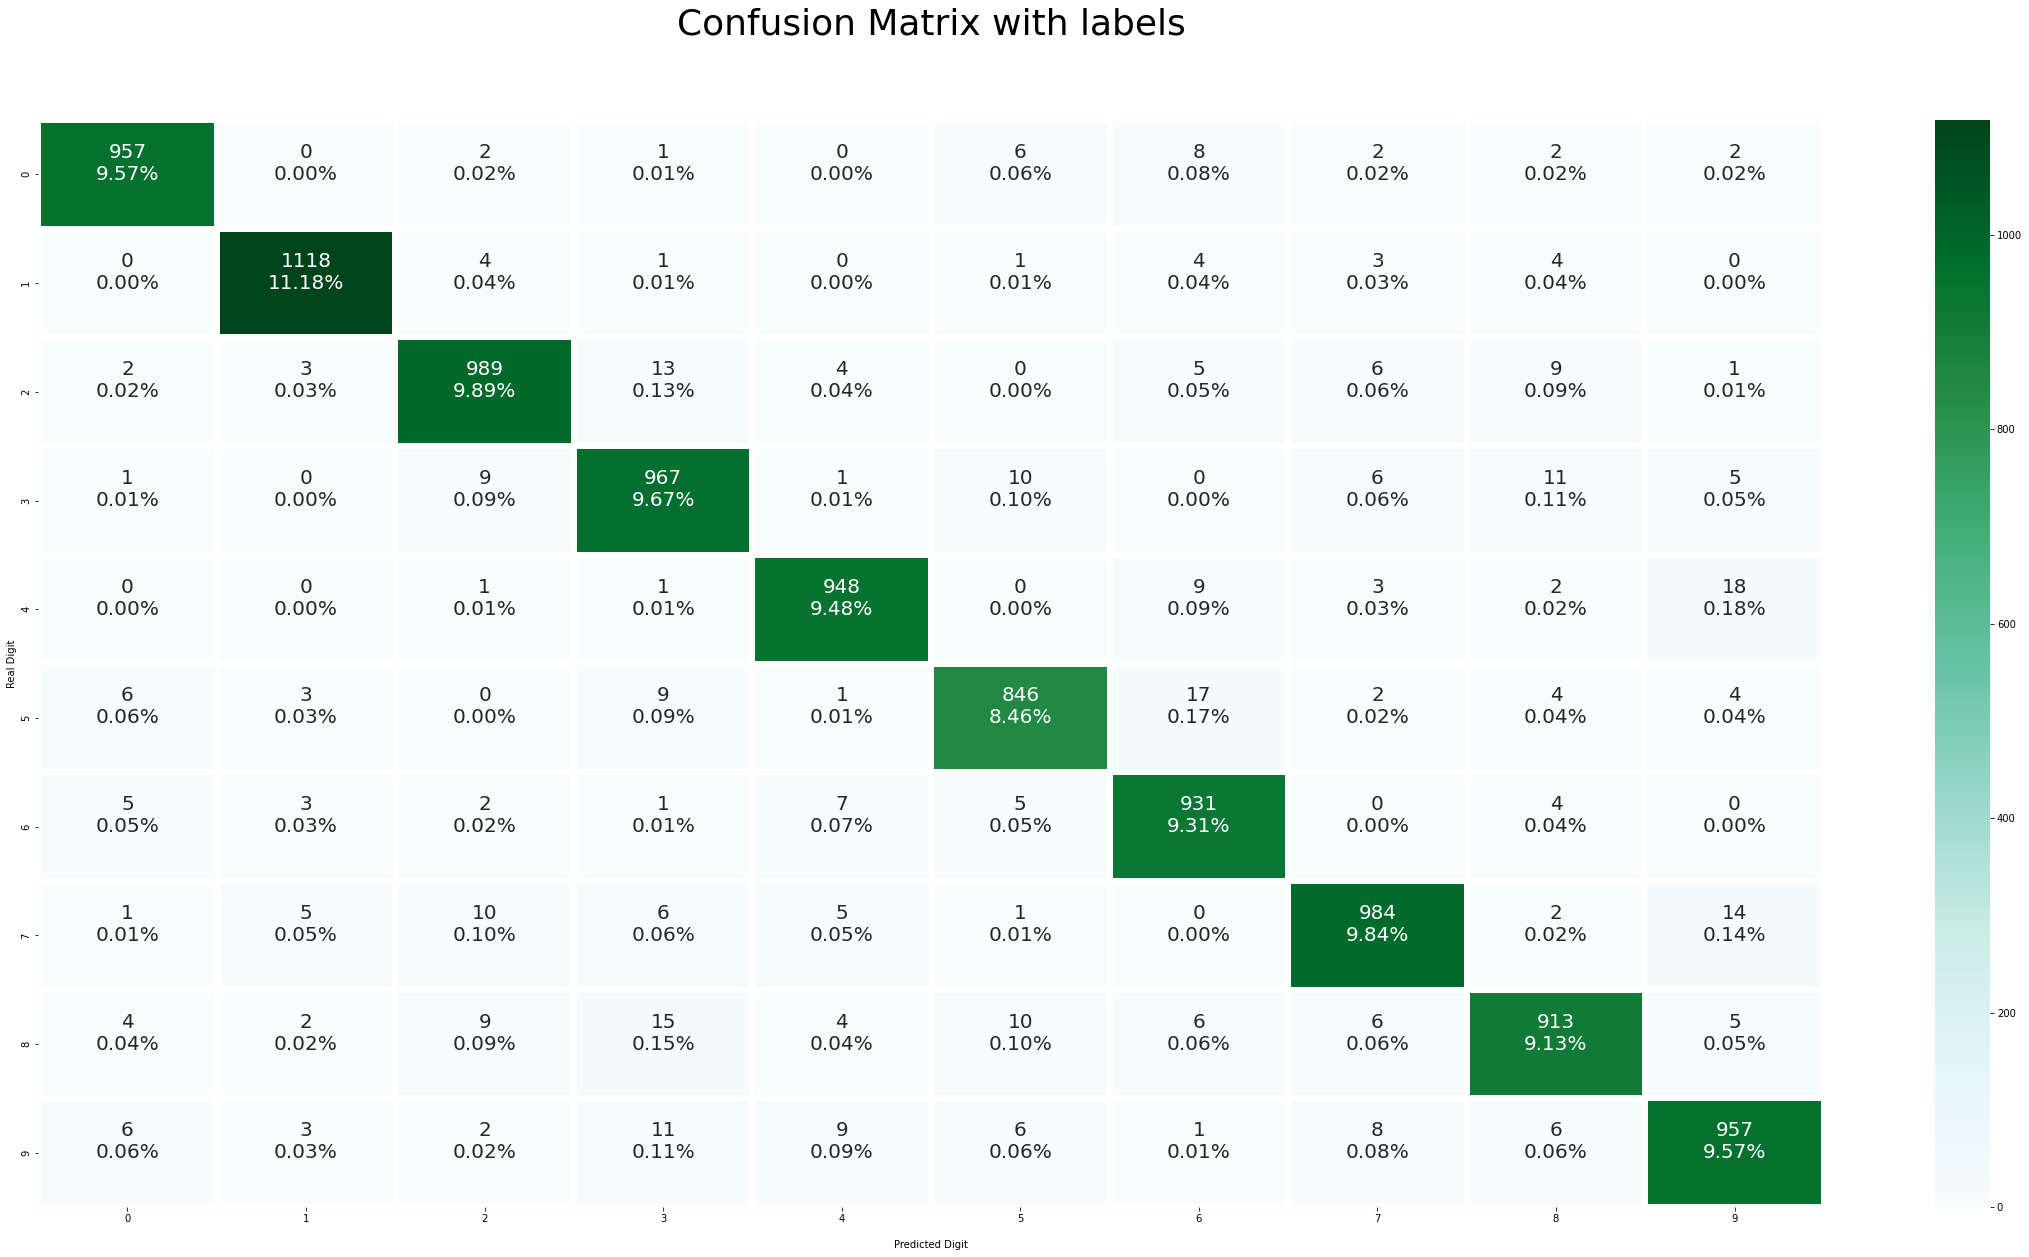


 
 The ACCURACY of the model is  96.10%


In [48]:
confusion_matrix(Y_test, jax.nn.one_hot(Y_hat, 10))

The accuracy of my model is 96.10% that is a really high accuracy. From the confusion matrix it is possible to notice that most of the errors occur missclassifying 4 as 9 and 8 with 3. 

11. Determine the indices of the first 50 misclassified entries of the test dataset, and use the `visualize_digits_and_labels_and_predictions` to visualize the misclassified images.

In order to perform the task, I modified the `visualize_digits_and_labels_and_predictions` function so that it calculate the indices of the first 50 missclassified digits and show the corresponding images:

In [49]:
def visualize_digits_WRONGpredictions(X: np.ndarray, Y: np.ndarray, Y_hat: np.ndarray) -> None:
    """Visualize digits as images and labels & predictions as titles."""
    # Check input arguments
    assert X.shape[0] == Y.shape[0] == Y_hat.shape[0]
    m = X.shape[0]
    assert X.shape[1] == 28 * 28
    assert Y.shape[1] == 10
    assert Y_hat.shape[1] == 10

    # Reverse one-hot encoding to determine the digit number
    digits = np.argwhere(Y == 1)[:, 1]

    # Determine predicted digit from probability distributions
    digits_hat = np.argmax(Y_hat, axis=1)
    
    indices_wrong = []
    digits_new = []
    digits_hat_new = []
    
    for i in range(len(digits)):
        if digits[i] != digits_hat[i]:
            indices_wrong.append(i)
            digits_new.append(digits[i])
            digits_hat_new.append(digits_hat[i])
            if len(indices_wrong) >= 50:
                break
    X_new = X[indices_wrong, ]

    # Create a new figure with 10 images per row, and assign titles to each subplot
    ncols = 10
    nrows = int(np.ceil(X_new.shape[0] / ncols))
    fig = plotly.subplots.make_subplots(
        rows=nrows, cols=ncols,
        subplot_titles=[str(d) + " vs " + str(d_hat) for (d, d_hat) in zip(digits_new, digits_hat_new)]
    )
    
    # Loop over images and add to subplot
    j = 0
    for row in range(nrows):
        for col in range(ncols):
            if j >= m:
                break
                
            img_j = X_new[j].reshape((28, 28))
            fig.add_heatmap(z=img_j, colorscale="gray_r", showscale=False, row=row + 1, col=col + 1)
            j += 1

    fig.update_yaxes(autorange="reversed", constrain="domain", scaleanchor="x", showticklabels=False)
    fig.update_xaxes(constrain="domain", showticklabels=False)
    
    print("The indices of the firt 50 missclassified digits are: \n", indices_wrong)
    fig.show()
                

In [50]:
visualize_digits_WRONGpredictions(X_test, Y_test, jax.nn.one_hot(Y_hat, 10))

The indices of the firt 50 missclassified digits are: 
 [8, 18, 61, 211, 247, 259, 290, 321, 340, 352, 381, 435, 445, 447, 448, 495, 530, 531, 578, 582, 591, 628, 629, 645, 659, 691, 717, 830, 839, 881, 882, 944, 947, 956, 965, 1014, 1024, 1039, 1044, 1107, 1112, 1114, 1166, 1178, 1181, 1182, 1194, 1226, 1232, 1234]
